In [1]:
# Import the necessary components
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from epydemix.utils import combine_simulation_outputs

In [2]:
# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
    parameters={
        'beta': 0.3,  # Transmission rate
        'gamma': 0.1  # Recovery rate
    }
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', rate='beta', agent='I')
sir_model.add_transition(source='I', target='R', rate='gamma')

print(sir_model)

EpiModel(name='SIR Model')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, rate: beta
    I -> R, rate: gamma
Parameters: 2
  Model parameters:
    beta: 0.3
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



In [3]:
# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'I': 10,   
    'R': 0     
}

# running the simulations
sir_results = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10",
    initial_conditions_dict=initial_conditions,
    Nsim=100,
    resample_frequency="3min", 
    dt = 1/3
)

In [4]:
sir_results.get_df_quantiles()

,S_0,S_total,I_0,I_total,R_0,R_total,quantile,date
0,99987.000,99987.000,9.00,9.00,0.00,0.00,0.025,2024-01-01 00:00:00
1,99987.000,99987.000,9.00,9.00,0.00,0.00,0.025,2024-01-01 00:03:00
2,99987.000,99987.000,9.00,9.00,0.00,0.00,0.025,2024-01-01 00:06:00
3,99987.000,99987.000,9.00,9.00,0.00,0.00,0.025,2024-01-01 00:09:00
4,99987.000,99987.000,9.00,9.00,0.00,0.00,0.025,2024-01-01 00:12:00
...,...,...,...,...,...,...,...,...
336002,6144.675,6144.675,1714.05,1714.05,93451.00,93451.00,0.975,2024-04-09 23:48:00
336003,6144.675,6144.675,1714.05,1714.05,93451.00,93451.00,0.975,2024-04-09 23:51:00
336004,6144.675,6144.675,1714.05,1714.05,93451.00,93451.00,0.975,2024-04-09 23:54:00
336005,6144.675,6144.675,1714.05,1714.05,93451.00,93451.00,0.975,2024-04-09 23:57:00


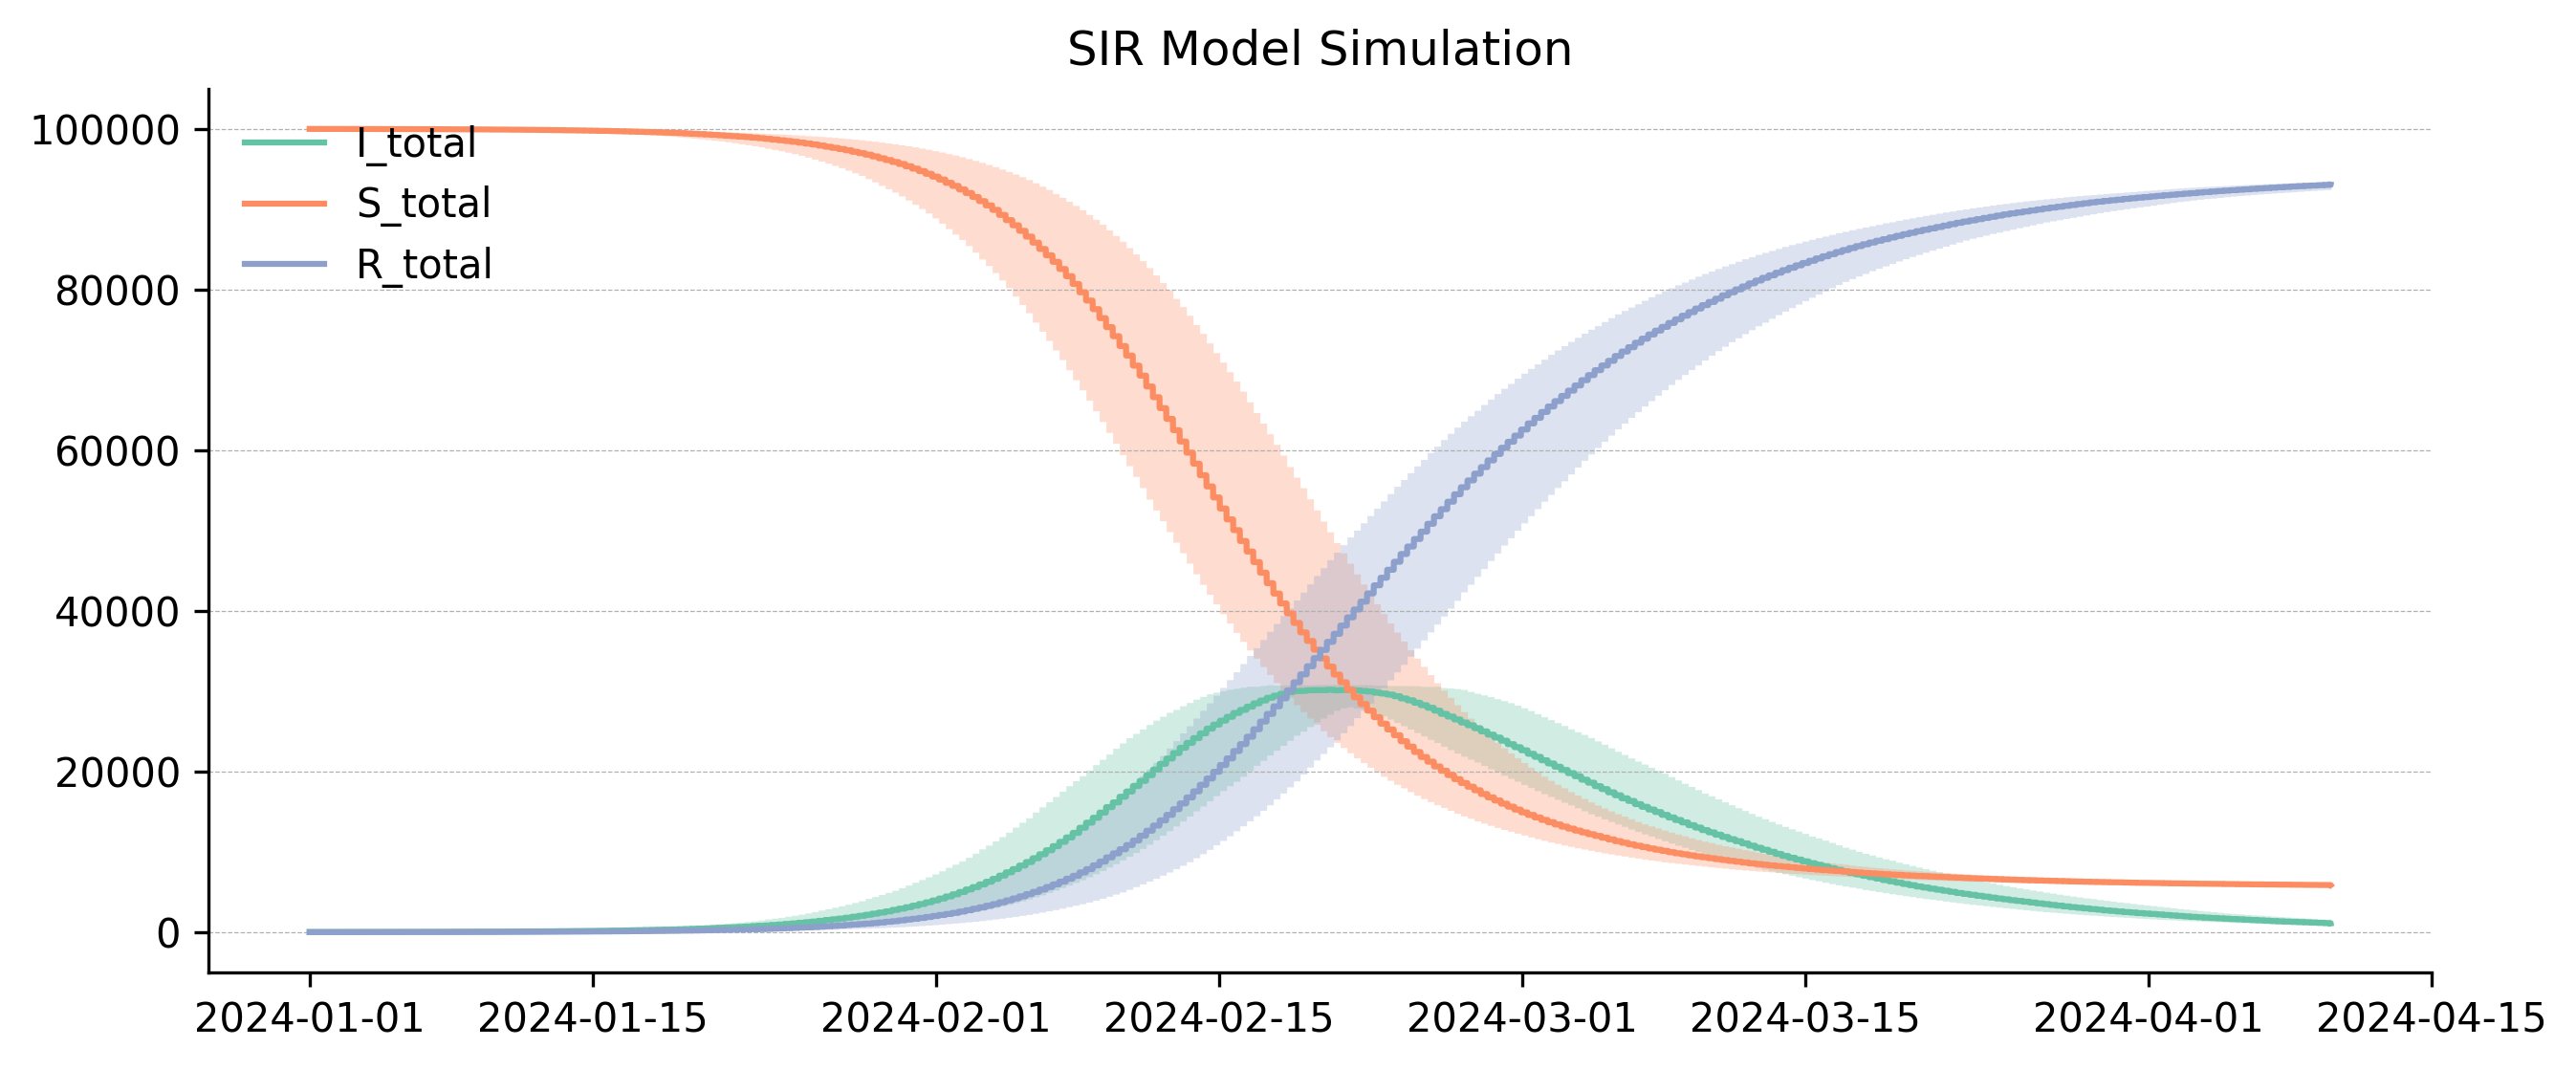

In [5]:
plot_quantiles(sir_results, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation')

In [6]:
import pandas as pd 
import os 

path_to_data = "https://raw.githubusercontent.com/ngozzi/epydemix-data/main/"
population_name = "Italy"
pd.read_csv(os.path.join(path_to_data, "data", population_name, "demographic/age_distribution.csv"))

,group_name,value
0,0,386291
1,1,404424
2,2,413367
3,3,414467
4,4,424150
...,...,...
80,80,463480
81,81,440035
82,82,463928
83,83,442826


In [7]:
from scipy import stats 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
from epydemix.model import EpiModel, simulate
from epydemix.visualization import plot_distance_distribution, plot_selected_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import calibrate, rmse
from epydemix.utils import compute_simulation_dates

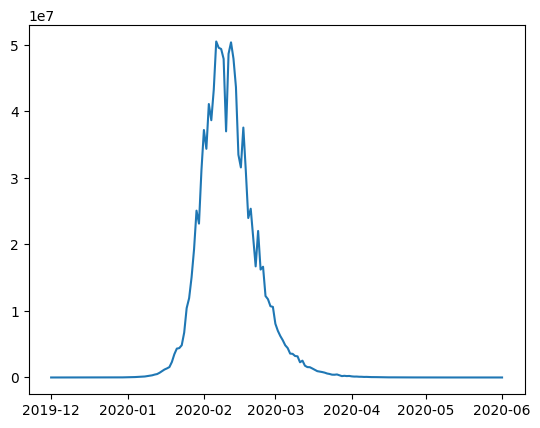

In [8]:
data = pd.read_csv('./data/data_I.csv')
data["date"] = pd.to_datetime(data["date"])

plt.plot(data["date"], data["I"], label="I")

In [9]:
model = EpiModel(predefined_model='SIR')
model.import_epydemix_population(population_name="Indonesia")
print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, rate: transmission_rate
    Infected -> Recovered, rate: recovery_rate
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Indonesia
  Population size: 282353643 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



In [ ]:
# initial conditions (we assume fully S population except for one infected individual in each age group)
initial_conditions = {"Susceptible": model.population.Nk - np.ones(len(model.population.Nk)), 
                      "Infected": np.ones(len(model.population.Nk)),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "simulation_dates": simulation_dates}

priors = {"transmission_rate": stats.uniform(0.015, 0.025), 
          "recovery_rate": stats.uniform(0.15, 0.25)}

# This function is needed as wrapper around simulate 
# to tell the calibration function which is the output
# quantity to compare with the data
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    results.update({"data": results["Infected_total"]})
    return results

start_time = time.time()
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["I"].values}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse)
end_time = time.time()  
print("ABC-SMC - Elapsed time: ", np.round(end_time - start_time, 2), "seconds")

ValueError: The function simulate_wrapper must return a dictionary, but it returned <class 'list'>.

In [22]:
posterior_samples.update(posterior_sample)

In [ ]:
posterior_samples

In [ ]:
results_abc_smc.get_selected_trajectories()[0]

In [ ]:
simulations